<a href="https://colab.research.google.com/github/reibek/progn-semestral-work/blob/main/Progonstics_Semestral_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eviroment prepare

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data
We can load data either from device or mount our Google Drive, where is data file located.

### From device
After running script a classic dialod window is open for choosing file to load.

In [2]:
# from google.colab import files
# uploaded = files.upload()

# import io
# dataset = pd.read_csv(io.BytesIO(uploaded['ADA-USD.csv']))

### From Google Drive
Mounting of drive is required.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After that, we can load our data file.

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/FRI/PROGN/ADA-USD.csv')

Preview of loaded data.

In [5]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-01,0.021678,0.032226,0.017354,0.024969,0.024969,50068700.0
1,2017-10-02,0.024607,0.030088,0.019969,0.025932,0.025932,57641300.0
2,2017-10-03,0.025757,0.027425,0.020690,0.020816,0.020816,16997800.0
3,2017-10-04,0.020864,0.022806,0.020864,0.021931,0.021931,9000050.0
4,2017-10-05,0.021951,0.022154,0.020859,0.021489,0.021489,5562510.0


Procedures definitions

# Procedures

In [6]:
def model_results(y_true, y_pred):
    n = y_true.size

    residuals = y_pred - y_true
    bias = np.sum(residuals) / n
    max_error = np.max(np.abs(residuals))
    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

    mean_squared_error = np.sum(residuals ** 2) / n
    root_mean_squared_error = np.sqrt(mean_squared_error)
    mean_absolute_error = np.sum(np.abs(residuals)) / n
    mean_absolute_percentage_error = np.sum(np.abs(residuals) / y_true) / n
    mean_percentage_error = np.sum(residuals / y_true) / n
    theil_coeff = np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2)

    print('=' * 37)
    print('Model metrics')
    print('=' * 37)
    print(f"{'Bias (Average error):':<25}{round(bias, 4):>12}")
    print(f"{'Max error:':<25}{round(max_error, 4):>12}")
    print(f"{'R-squared:':<25}{round(r_squared, 4):>12}")
    print(f"{'MSE:':<25}{round(mean_squared_error, 4):>12}")
    print(f"{'RMSE:':<25}{round(root_mean_squared_error, 4):>12}")
    print(f"{'MAE:':<25}{round(mean_absolute_error, 4):>12}")
    print(f"{'MAPE:':<25}{round(mean_absolute_percentage_error, 4):>12}")
    print(f"{'MPE:':<25}{round(mean_percentage_error, 4):>12}")
    print(f"{'Theil coefficient:':<25}{round(theil_coeff, 4):>12}")


def r_squared(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


def mean_squared_error(y_true, y_pred):
    n = y_true.size
    residuals = y_pred - y_true
    return np.sum(residuals ** 2) / n


def root_mean_squared_error(y_true, y_pred):
    n = y_true.size
    residuals = y_pred - y_true
    return np.sqrt(np.sum(residuals ** 2) / n)


def mean_absolute_error(y_true, y_pred):
    n = y_true.size
    residuals = y_pred - y_true
    return np.sum(np.abs(residuals) / y_true) / n


def mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.size
    residuals = y_pred - y_true
    return np.sum(np.abs(residuals) / y_true) / n


def mean_percentage_error(y_true, y_pred):
    n = y_true.size
    residuals = y_pred - y_true
    return np.sum(residuals / y_true) / n


def theil_coefficient(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2)


def show_trends(data_x, data_y):
    # Number of values in data
    n = data_x.size
    # Truncate data from beginning by 2 values
    data_x_trunc = data_x[2:]
    data_y_trunc = data_y[2:]
    # Create vector of first differences
    diff1 = np.zeros(n - 2)
    for i in range(0, n - 2):
        diff1[i] = data_y[i + 2] - data_y[i + 1]
    # Create vector of second differences
    diff2 = np.zeros(n - 2)
    for i in range(0, n - 2):
        diff2[i] = data_y[i + 2] - (2 * data_y[i + 1]) + data_y[i]
    # Create vector of growth coefficients
    growth_coeff = np.zeros(n - 2)
    for i in range(0, n - 2):
        growth_coeff[i] = data_y[i + 2] / data_y[i + 1]
    # Create vector of first differences data's logarithms
    diff1_log = np.zeros(n - 2)
    for i in range(0, n - 2):
        diff1_log[i] = np.log(data_y[i + 2]) - np.log(data_y[i + 1])

    fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=5)
    plt.tight_layout()

    axes[0].set_title('Original data plot')
    axes[1].set_title('First differences')
    axes[2].set_title('Second differences')
    axes[3].set_title('Coefficients of growth')
    axes[4].set_title('First differences of logarithms')

    axes[0].plot(data_x, data_y, color='r')
    axes[1].plot(data_x_trunc, diff1)
    axes[2].plot(data_x_trunc, diff2)
    axes[3].plot(data_x_trunc, growth_coeff)
    axes[4].plot(data_x_trunc, diff1_log)


def first_naive(pd_dataset, column_name):
    return pd_dataset[column_name].shift(1)


def second_naive(pd_dataset, column_name):
    return pd_dataset[column_name].shift(1) + pd_dataset[column_name].diff().shift(1)


def third_naive(pd_dataset, column_name):
    return pd_dataset[column_name].shift(1) * pd_dataset[column_name].shift(1) / pd_dataset[column_name].shift(2)


def simple_moving_average(pd_dataset, column_name, window_size):
    return pd_dataset[column_name].rolling(window=window_size).mean()


def exponential_moving_average(pd_dataset, column_name, window_size):
    return pd_dataset[column_name].ewm(span=window_size, adjust=False).mean()


def single_exp_smoothing(pd_dataset, column_name, alpha):
    return pd_dataset[column_name].shift().ewm(alpha=alpha, adjust=False).mean()


def plot_data(x, y, x_label=None, y_label=None, fig_title=None, fig_size=None):
    """
    Plot given data.
  
    Parameters:
       x            x_data
       y            list[tuple(y_data, y_label)]
       x_label      string
       y_label      string
       fig_title    string
       fig_size     tuple(int, int)
    """

    fig = plt.figure(figsize=fig_size)
    axes = fig.add_subplot(111)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(fig_title)

    for axis in y:
        axes.plot(x, axis[0], label=axis[1])

    axes.legend(loc=0)
    plt.grid(True)
    plt.show()


# Data preprocessing
Format 'Date' column as `datetime` type.



In [7]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

We will be intrested only with column '**Close**', which represent price of ADA at the end of the day. Other columns we'll drop.

In [8]:
dataset.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

Summary of missing data.

In [9]:
dataset.isna().sum()

Date     0
Close    5
dtype: int64

Drop `NaN` values.

In [10]:
dataset = dataset.dropna()

Set index of dataset to '**Date**'.

In [11]:
dataset = dataset.set_index('Date')
dataset.index

DatetimeIndex(['2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10',
               ...
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=1245, freq=None)

Create datasets of week and month averages.

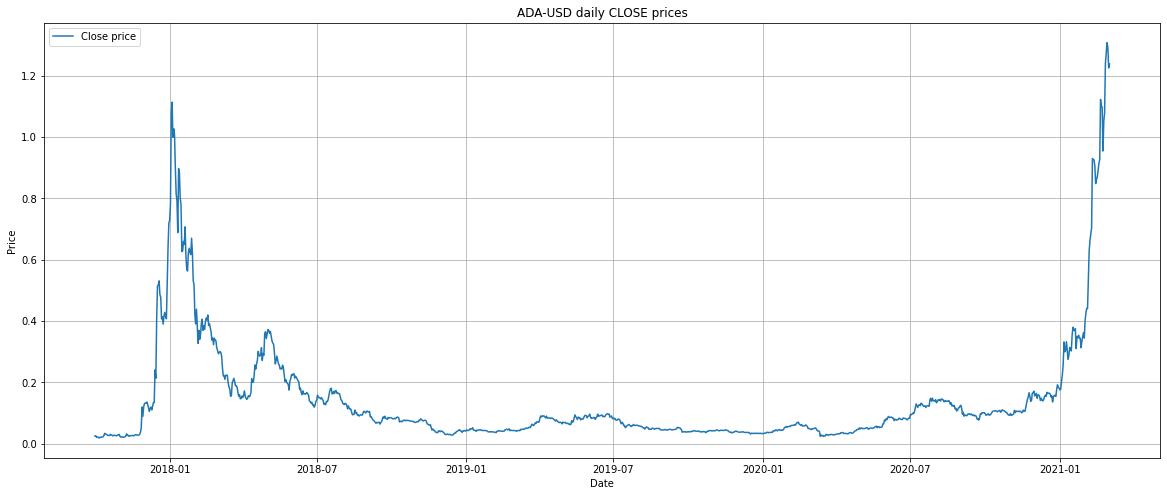

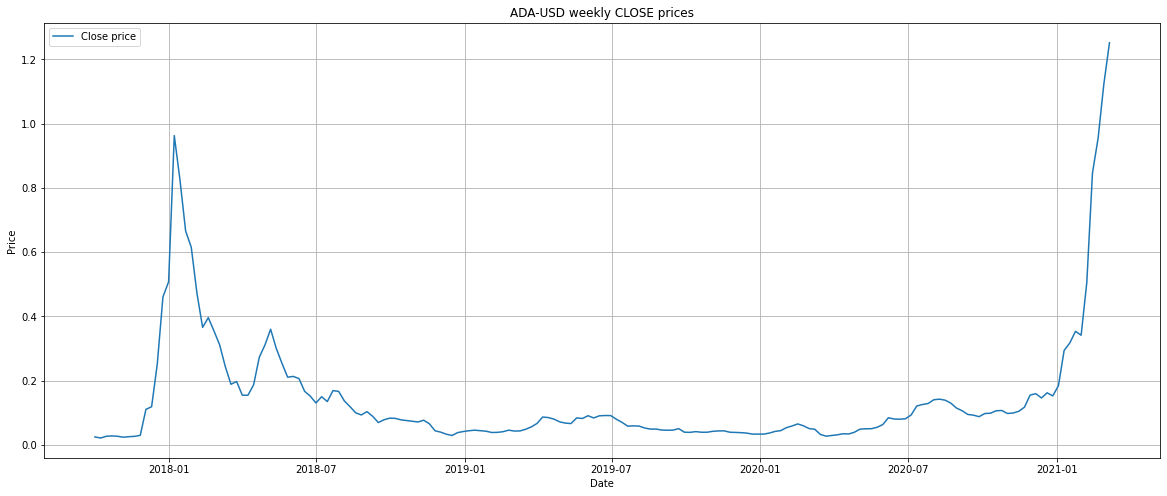

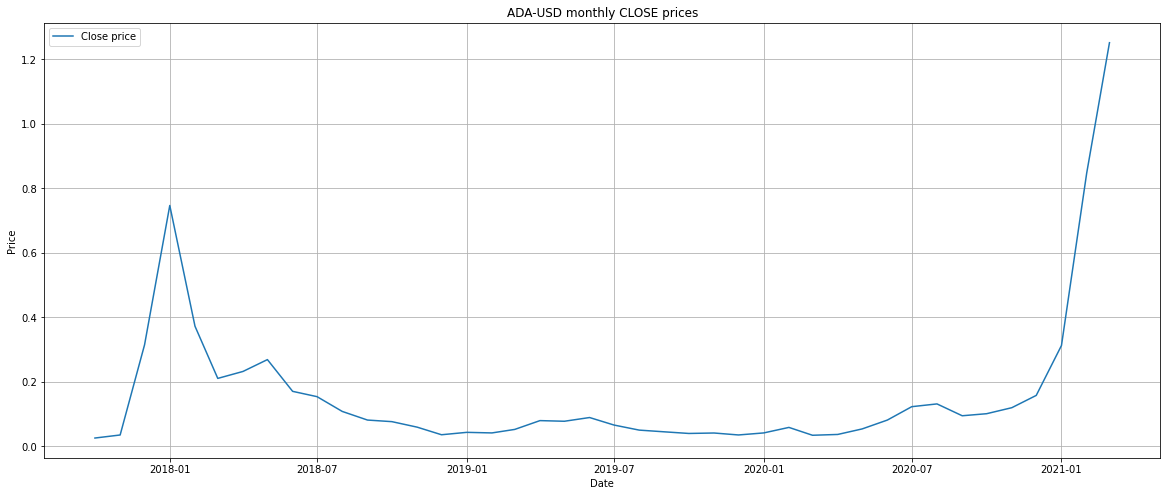

In [12]:
close_d = dataset['Close']
close_w = dataset['Close'].resample('W').mean()
close_m = dataset['Close'].resample('MS').mean()

rcParams['figure.figsize'] = 20, 8

plot_data(x=close_d.index, 
          y=[(close_d, 'Close price')],
          x_label='Date',
          y_label='Price',
          fig_title='ADA-USD daily CLOSE prices')

plot_data(x=close_w.index, 
          y=[(close_w, 'Close price')],
          x_label='Date',
          y_label='Price',
          fig_title='ADA-USD weekly CLOSE prices')

plot_data(x=close_m.index, 
          y=[(close_m, 'Close price')],
          x_label='Date',
          y_label='Price',
          fig_title='ADA-USD monthly CLOSE prices')

# Decomposition

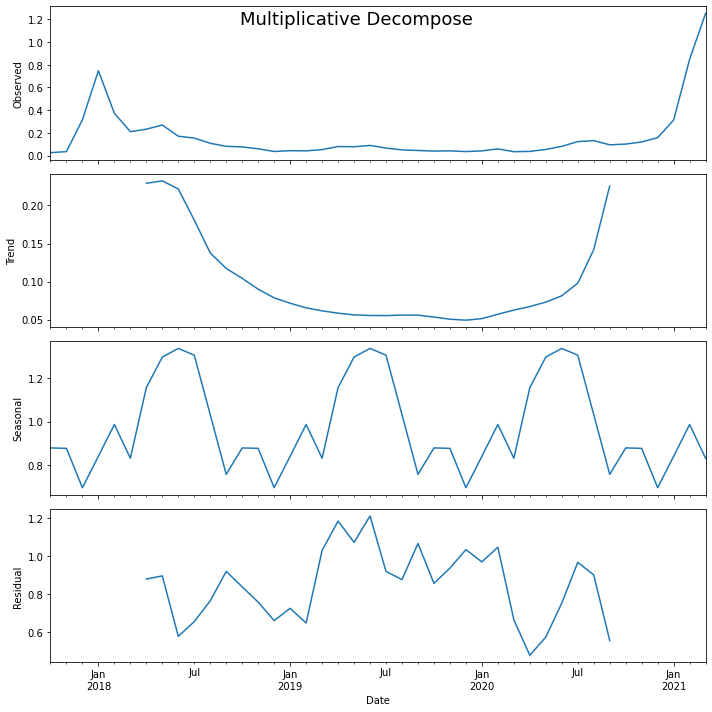

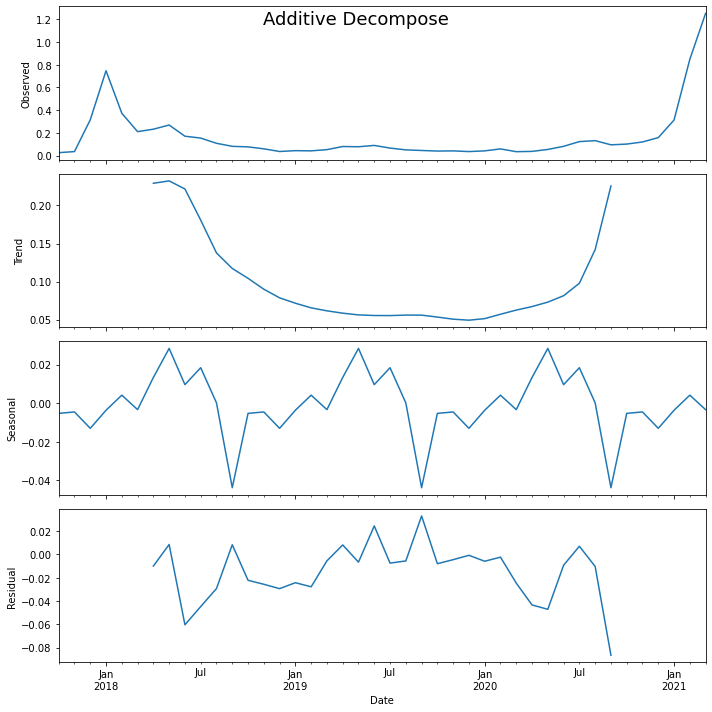

In [23]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(close_m, model='multiplicative')

# Additive Decomposition
result_add = seasonal_decompose(close_m, model='additive')

# Plot
rcParams['figure.figsize'] = 10, 10
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=18)
result_add.plot().suptitle('Additive Decompose', fontsize=18)
plt.show()

# Analysis

### Autocorrelation
Correlation of variable itself in time.

In [ ]:
plot_acf(dataset.Close, lags=50);

### Partial correlation

In [ ]:
plot_pacf(dataset.Close, lags=50);

In [ ]:
# decomposition = sm.tsa.seasonal_decompose(dataset.Close, model='additive')
# fig = decomposition.plot()
# plt.show()